# CLIP-goals: A Sanity Check

We are interested in determining whether goals described in language will have high similarity with the corresponding goal images and lower similarity with non-goal images. 

## Imports

In [1]:
import os
from IPython.display import display
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
import torch

In [2]:
from yaml import load, dump

try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

## Briefly setting up our (debug) dataset

There are 9 task trajectories in our episode. We'll have a 9x9 matrix with rows corresponding to language annotations and columns corresponding to image goals. The cells will contain the similarity of the CLIP embeddings. Ideally we see this similarity peaking along the diagonal.

In [3]:
DATA_PATH = "../data/calvin/calvin_debug_dataset/"
train_path = os.path.join(DATA_PATH, "training")

In [4]:
# this is an object array so we need to pass allow_pickle=True

lang_annotations = np.load(
    os.path.join(train_path, "lang_annotations", "auto_lang_ann.npy"), allow_pickle=True
)
lang_annotations_dict = lang_annotations.item()

In [5]:
# get array images
# the images we are interested in are the ones at the end of the task trajectories
# as specified by the language annotations

image_idxs = [end for (start, end) in lang_annotations_dict["info"]["indx"]]

images = [
    Image.fromarray(
        np.load(os.path.join(train_path, f"episode_0{idx}.npz"))["rgb_static"]
    )
    for idx in image_idxs
]

In [6]:
# get language_annotations
lang_anns = lang_annotations_dict['language']['ann']

image index 0: move the light switch to turn on the yellow light


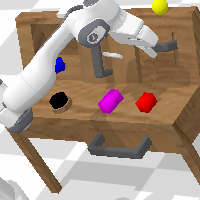



image index 1: sweep the pink block to the right


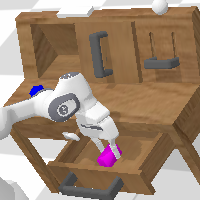



image index 2: place the block in the sliding cabinet


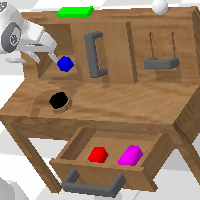



image index 3: pick up the red block from the table


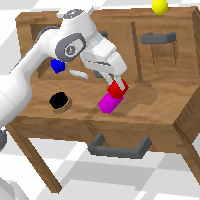



image index 4: in the slider grasp the blue block


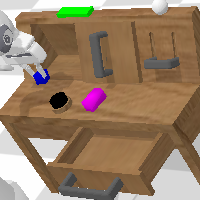



image index 5: slide down the switch


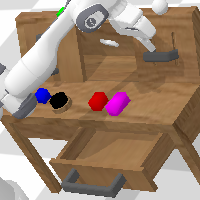



image index 6: pick up the red block on the table


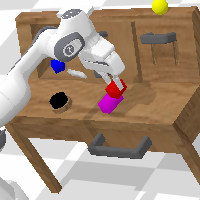



image index 7: place in slider


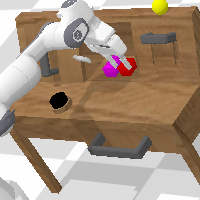



image index 8: turn off the light bulb


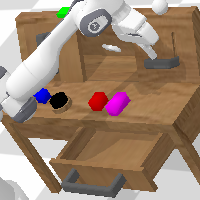

In [7]:
for i, (lang_ann, image) in enumerate(zip(lang_anns, images)):
    print(f"image index {i}: {lang_ann}")
    display(image)
    print("\n")

They look well-paired. Let's see

## Other Preliminaries

In [17]:
# First setup the model

MODEL_VARIANT = "laion/CLIP-ViT-L-14-laion2B-s32B-b82K"

clip_model = transformers.CLIPModel.from_pretrained(MODEL_VARIANT)
clip_processor = transformers.CLIPProcessor.from_pretrained(MODEL_VARIANT)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


## Functions

In [9]:
def calculate_matrices(
    lang_anns,
    images,
    processor,
    model,
    logits_per_image="logits_per_image",
    **processor_kwargs
):
    inputs = processor(
        text=lang_anns,
        images=images,
        padding=True,
        return_tensors="pt",
        **processor_kwargs
    )
    with torch.no_grad():
        outputs = model(**inputs)

    # transpose to have language as rows (first dimension), images as cols (second dimension)
    logits_per_image = outputs[logits_per_image].T
    probs = logits_per_image.softmax(dim=1)

    similarity_matrix = logits_per_image.detach().numpy()
    probability_matrix = probs.detach().numpy()

    return probability_matrix, similarity_matrix


def plot_heatmaps(probability_matrix, similarity_matrix, lang_anns, name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), dpi=300, sharey=True)
    ax1 = sns.heatmap(
        probability_matrix,
        ax=ax1,
        yticklabels=lang_anns,
        square=True,
        cbar_kws={"orientation": "horizontal", "location": "top"},
    )
    ax1.set_xlabel("Image Index")
    ax1.set_title("Softmaxed Probability")

    ax2 = sns.heatmap(
        similarity_matrix,
        ax=ax2,
        yticklabels=lang_anns,
        square=True,
        cbar_kws={"orientation": "horizontal", "location": "top"},
    )
    ax2.set_xlabel("Image Index")
    ax2.set_title("Similarity")
    f.suptitle(name)
    f.set_tight_layout(True)
    plt.show()


def run_my_pipeline(
    lang_anns,
    images,
    processor,
    model,
    name,
    logits_per_image="logits_per_image",
    **processor_kwargs
):
    print(name)
    print("calculating similarity")
    probability_matrix, similarity_matrix = calculate_matrices(
        lang_anns, images, processor, model, logits_per_image, **processor_kwargs
    )
    print("plotting")
    plot_heatmaps(probability_matrix, similarity_matrix, lang_anns, name)

## CLIP

https://openai.com/research/clip/

OpenCLIP
calculating similarity
plotting


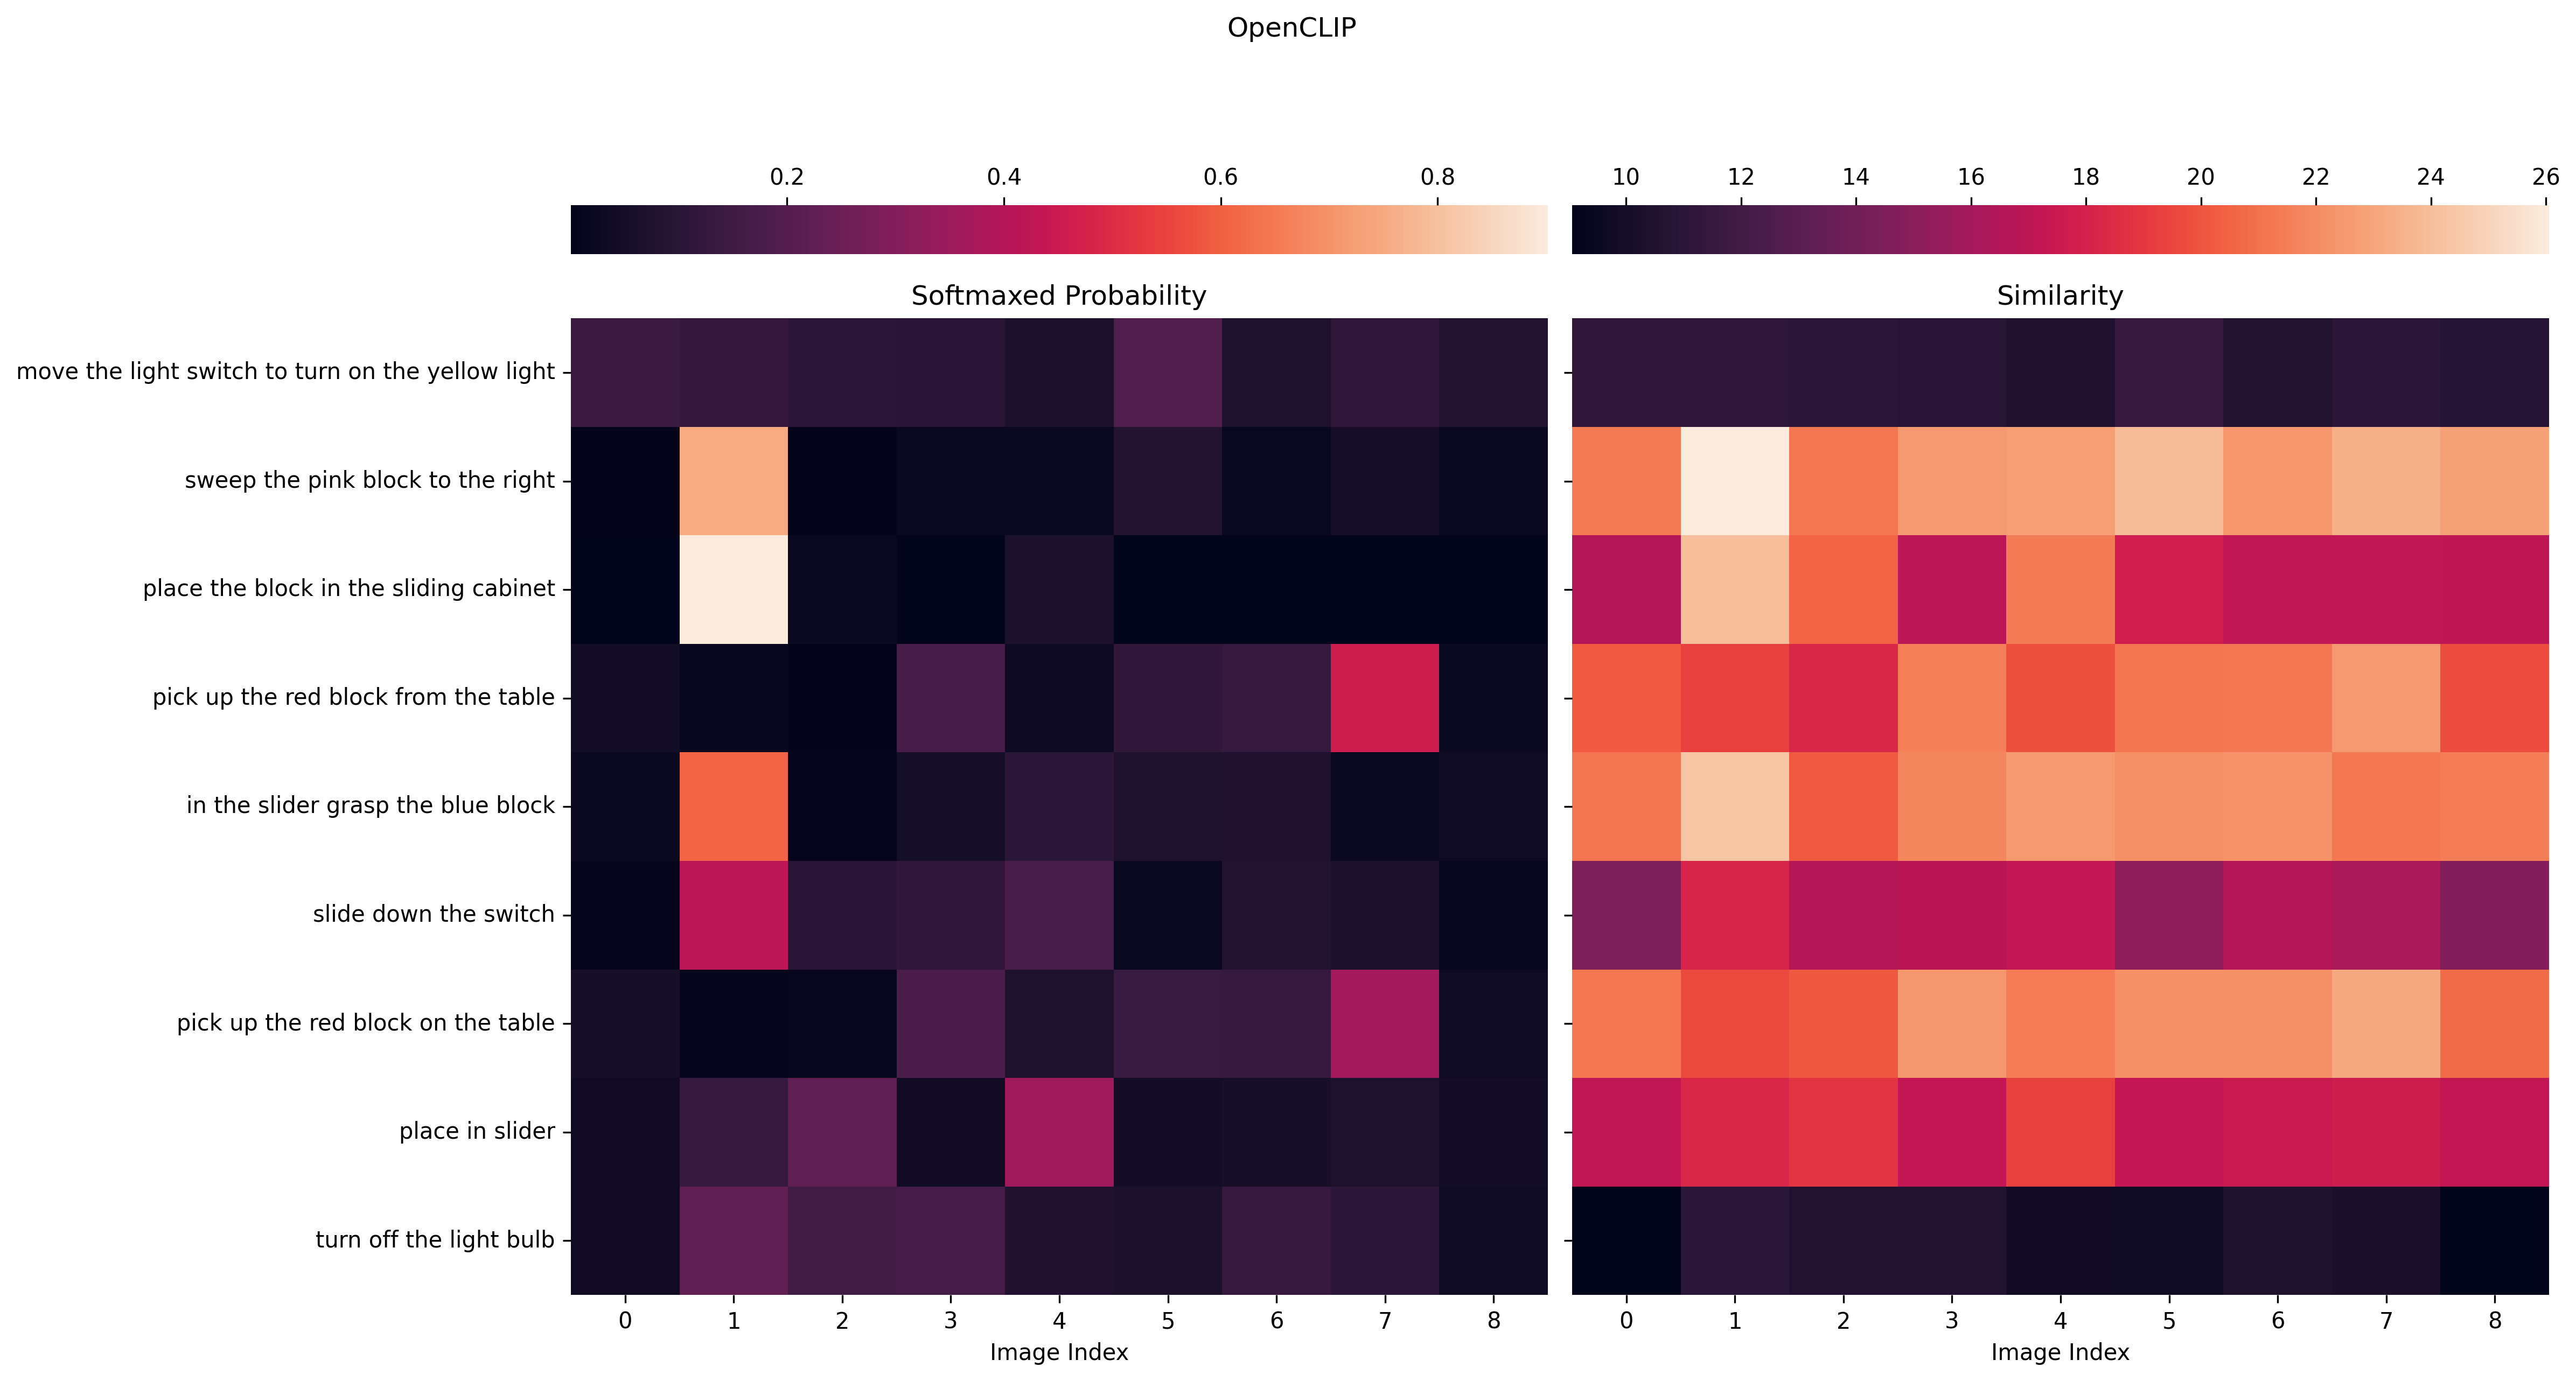

In [10]:
run_my_pipeline(lang_anns, images, clip_processor, clip_model, "OpenCLIP")

That didn't work very well it seemed. We should ideally see a diagonal on at least one of the two matrices. Let's try some other things before abandoning this route.

## Trying different Image-Language Models

We'll try

- ALIGN
- FLAVA

### ALIGN

https://ai.googleblog.com/2021/05/align-scaling-up-visual-and-vision.html

In [19]:
align_processor = transformers.AlignProcessor.from_pretrained("kakaobrain/align-base")
align_model = transformers.AlignModel.from_pretrained("kakaobrain/align-base")

ALIGN
calculating similarity


/Users/thesofakillers/miniconda3/envs/thesis/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


plotting


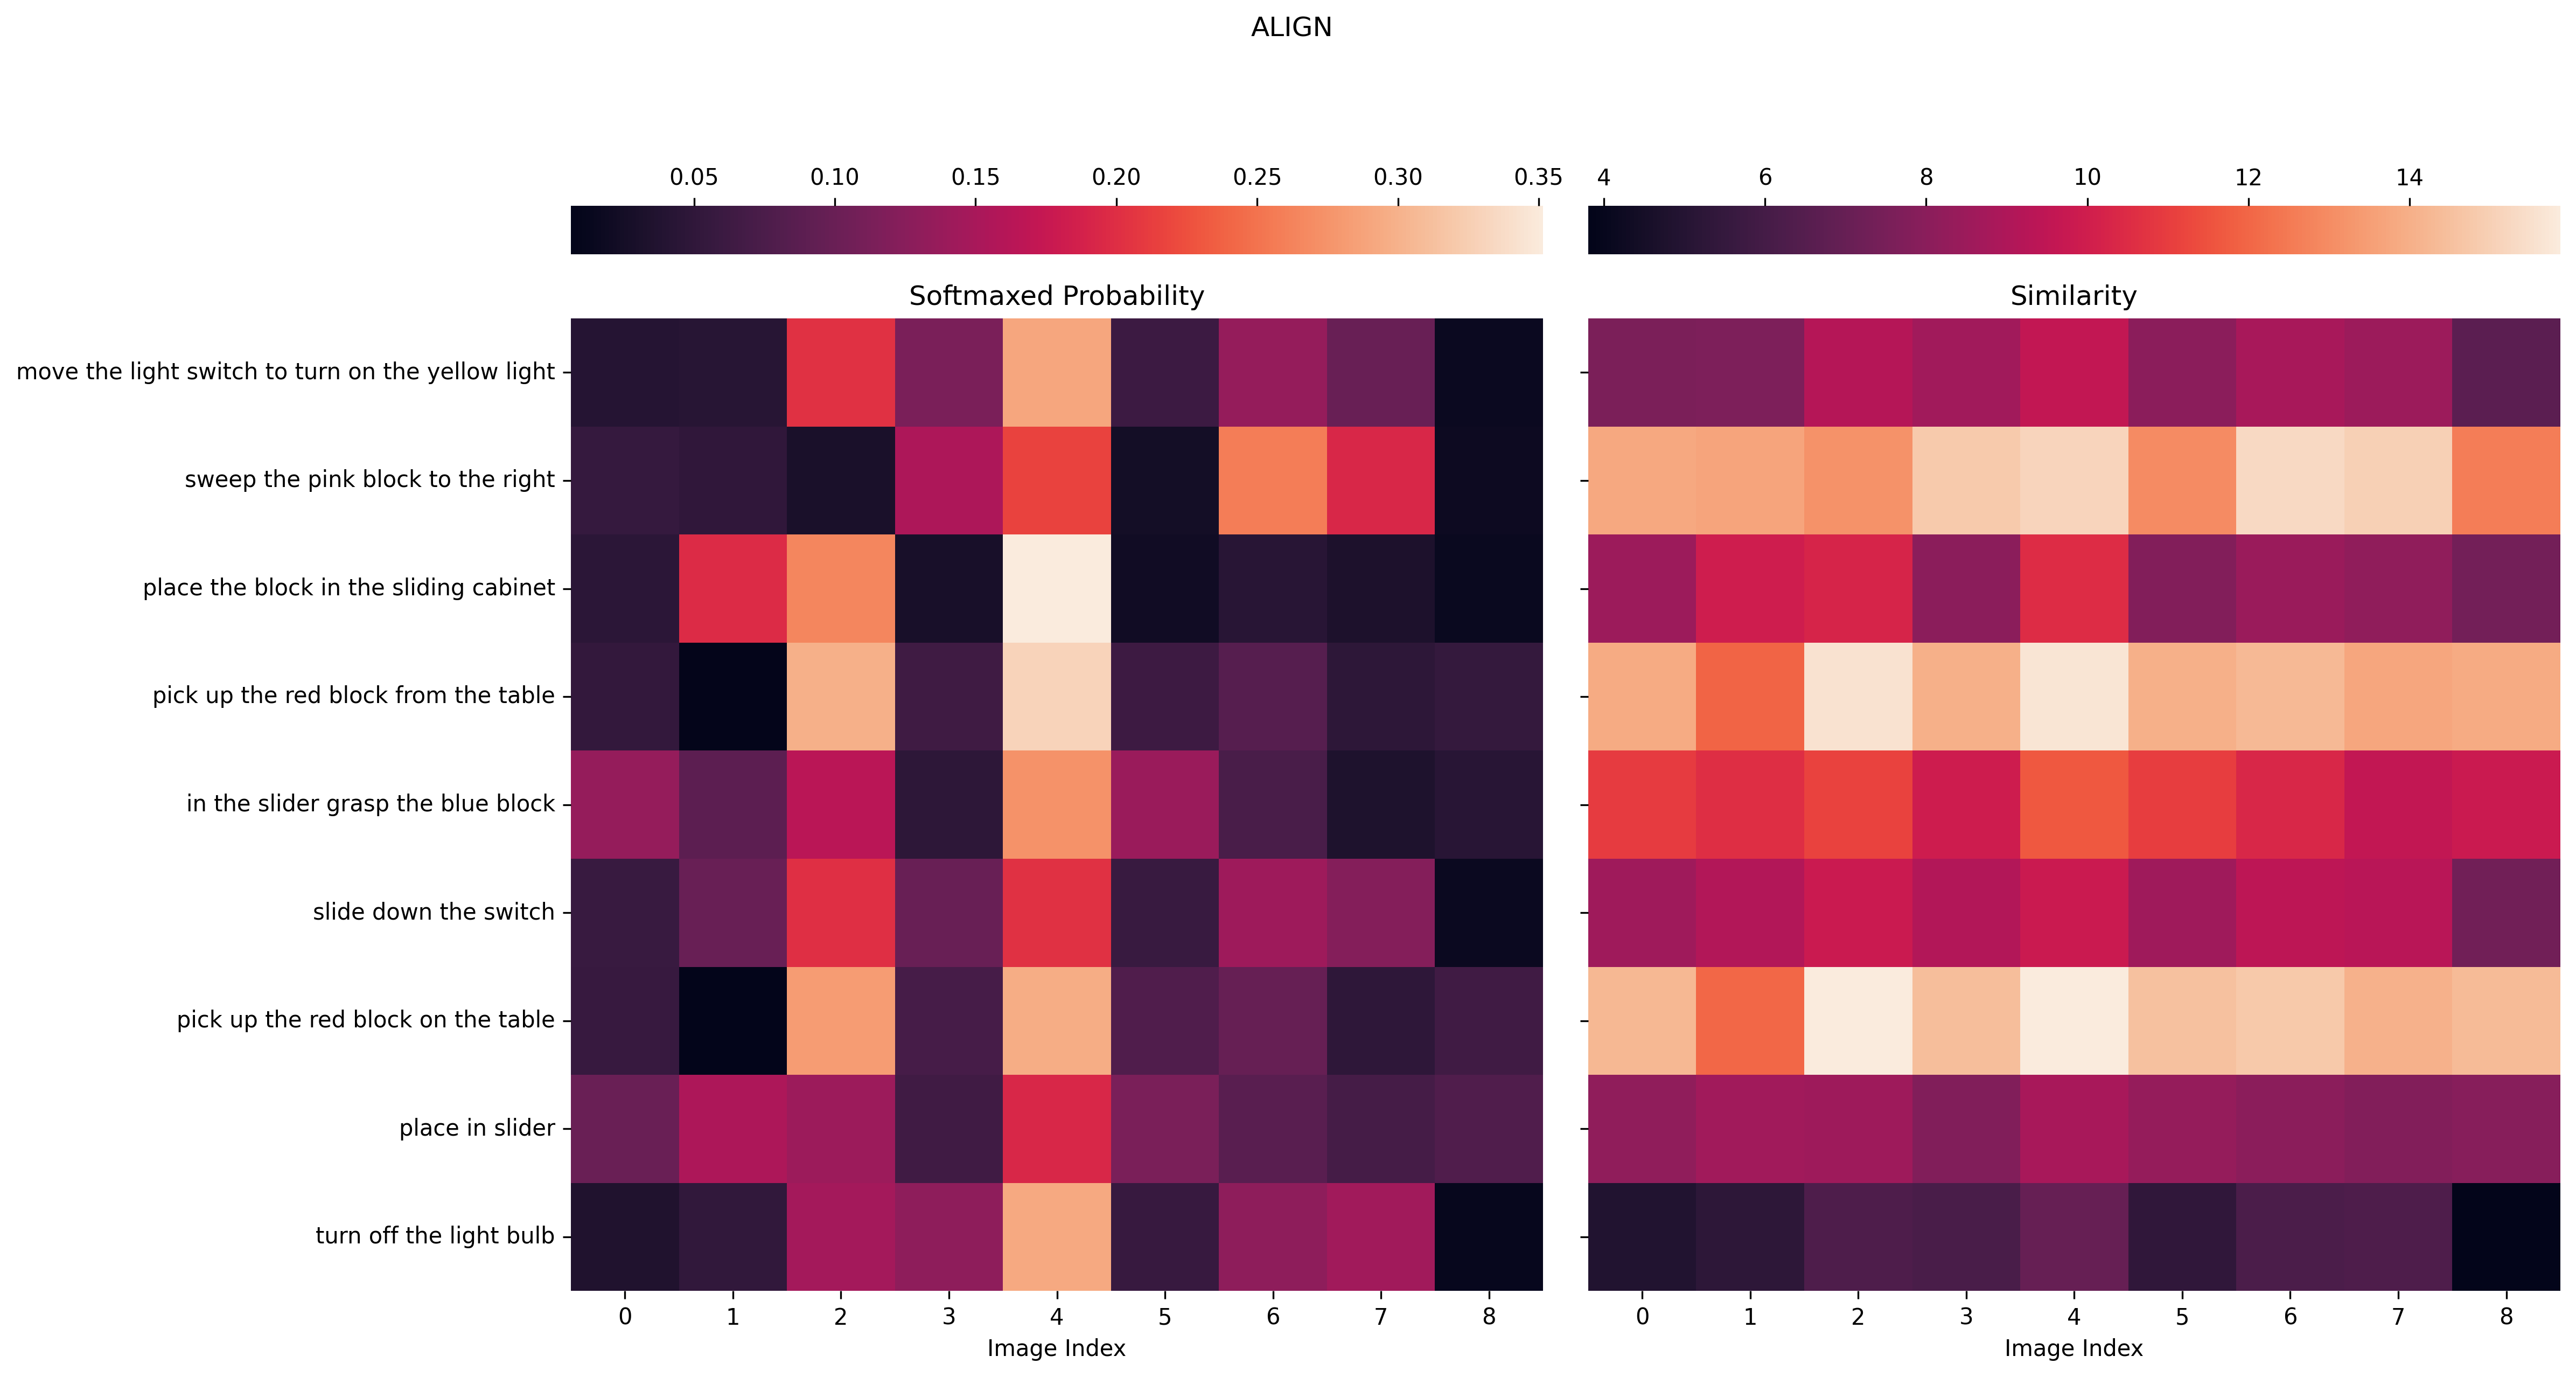

In [12]:
run_my_pipeline(lang_anns, images, align_processor, align_model, 'ALIGN')

### FLAVA

https://flava-model.github.io/

In [23]:
flava_model = transformers.FlavaForPreTraining.from_pretrained("facebook/flava-full")
flava_processor = transformers.FlavaProcessor.from_pretrained("facebook/flava-full")

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.


`input_ids_masked` isn't passed which means MLM loss won't be calculated correctlySetting it to `input_ids` so that model can work. Please pass it if this is unintentional. This is usually OKAY if you are doing inference on unmasked text...


FLAVA
calculating similarity


/Users/thesofakillers/miniconda3/envs/thesis/lib/python3.8/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


plotting


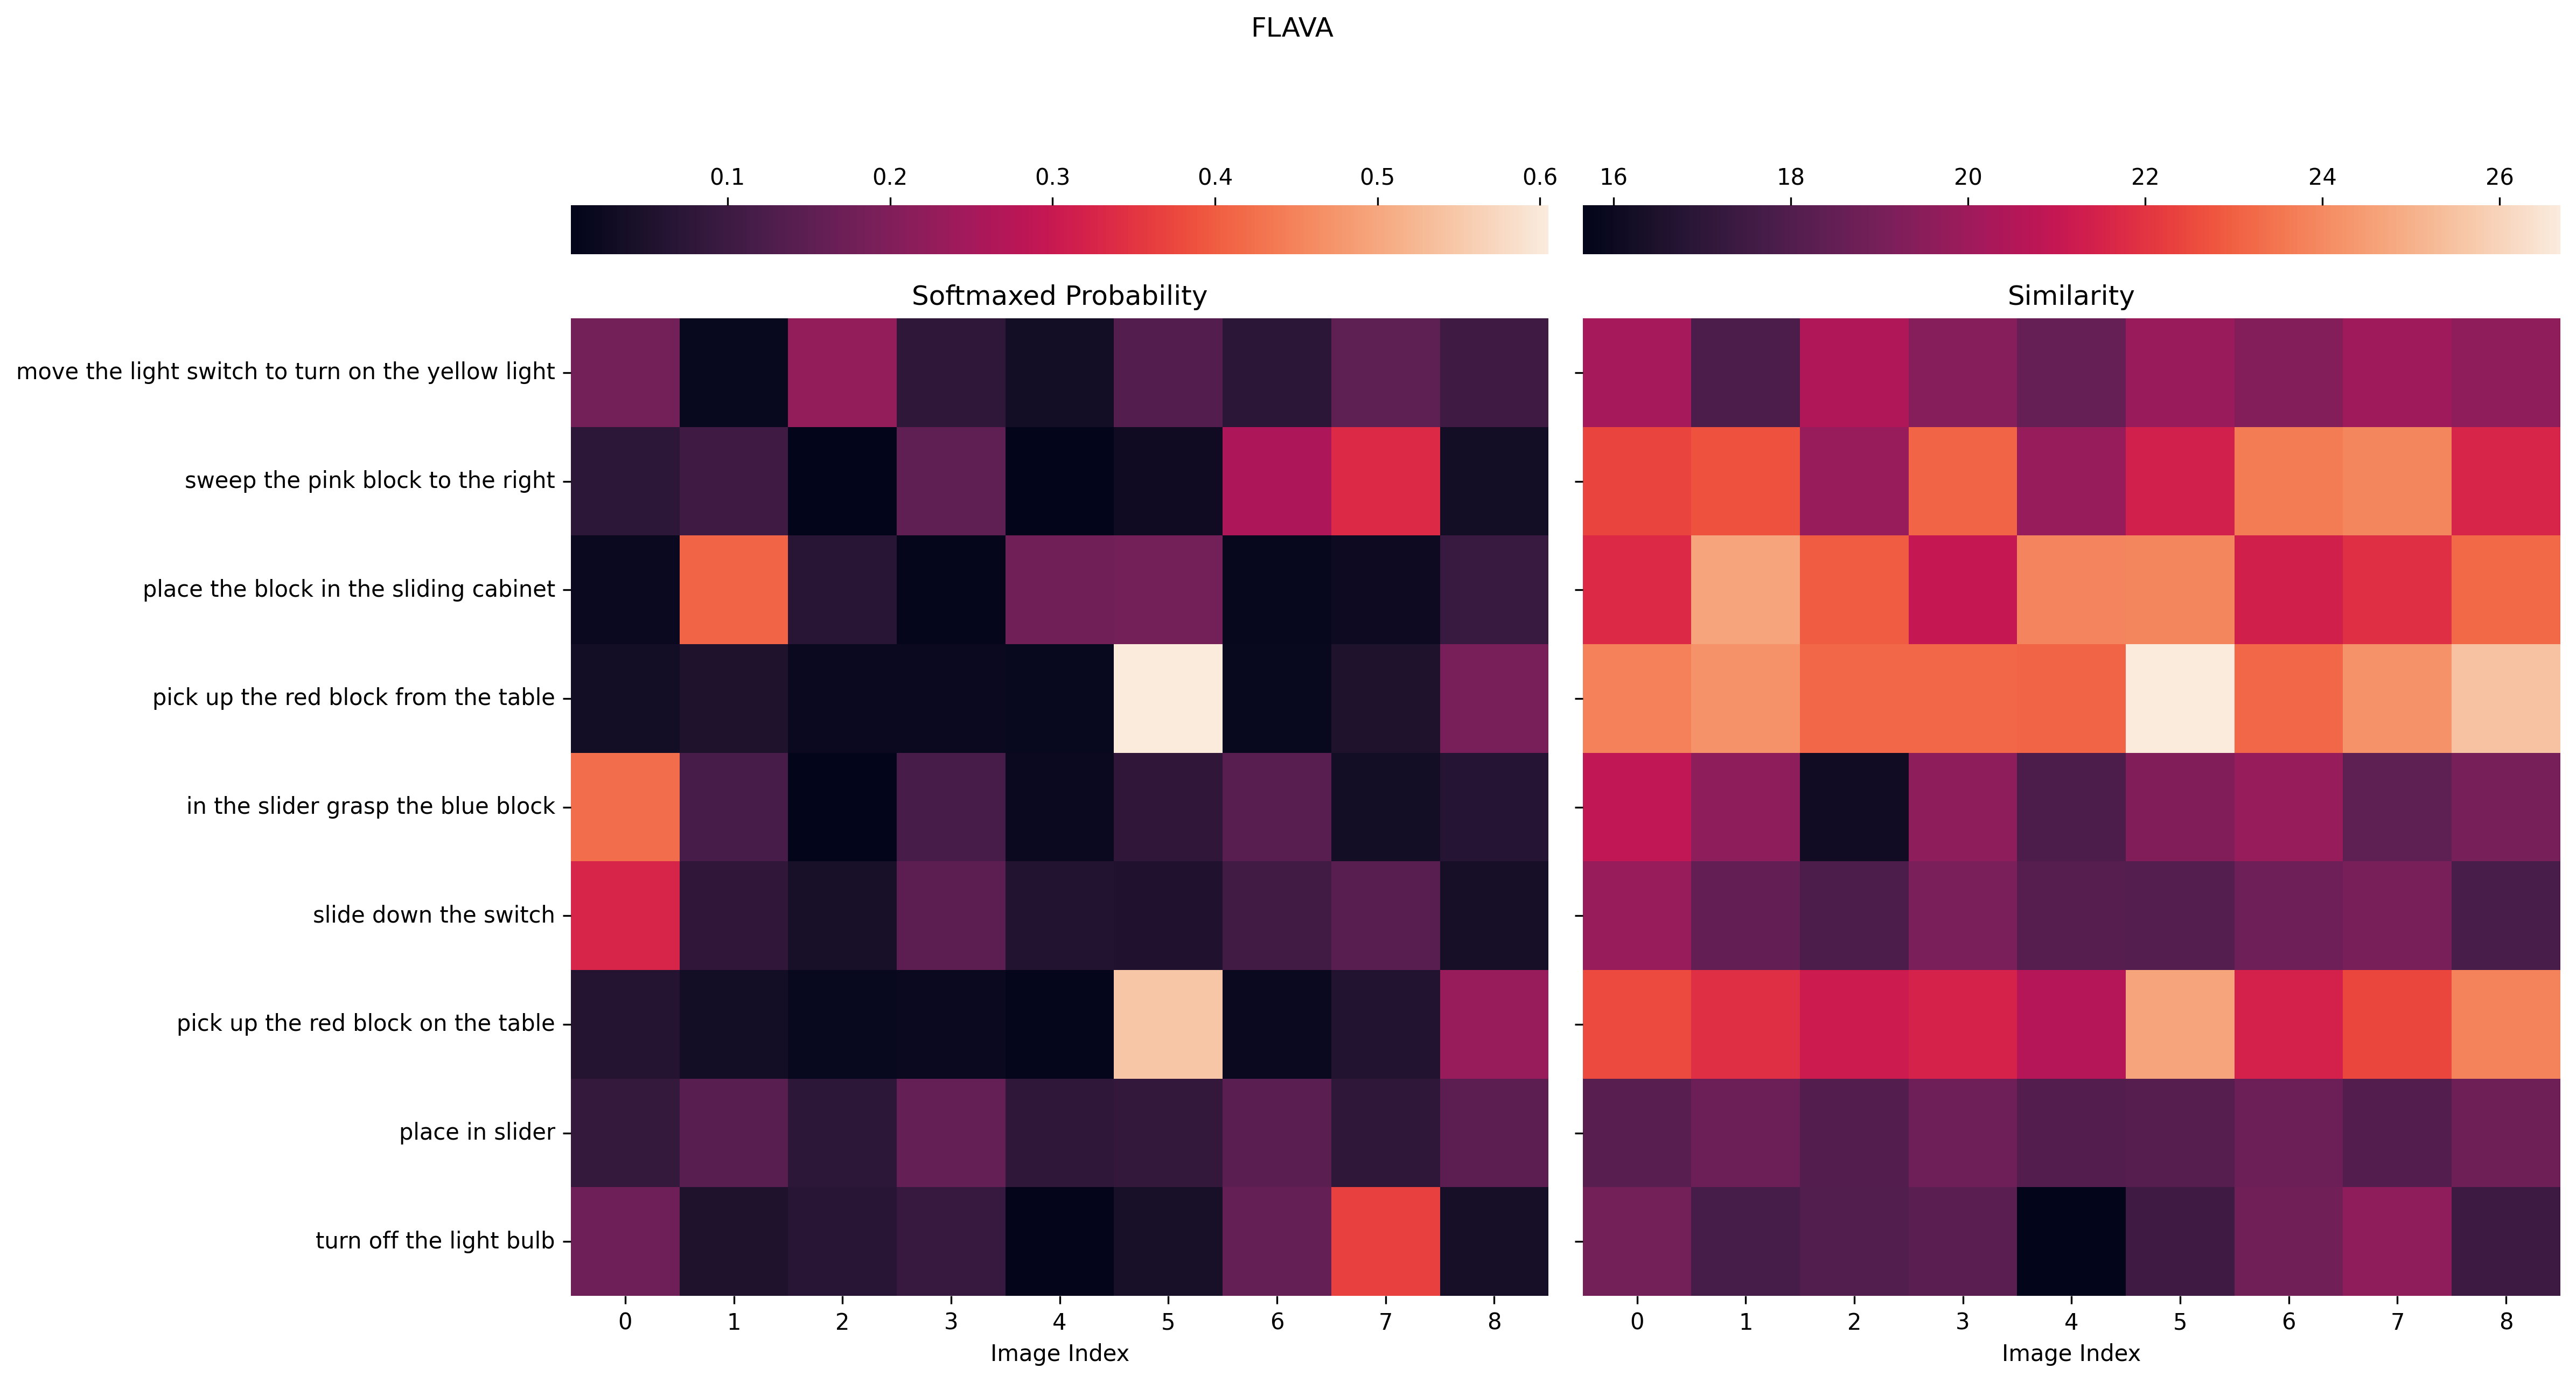

In [14]:
run_my_pipeline(
    lang_anns,
    images,
    flava_processor,
    flava_model,
    "FLAVA",
    "contrastive_logits_per_image",
    return_codebook_pixels=True,
    return_image_mask=True,
)

Still not seeing the correct diagonal. Maybe we can try some prompt-engineering.

## Prompt Engineering

In [15]:
lang_anns

['move the light switch to turn on the yellow light',
 'sweep the pink block to the right',
 'place the block in the sliding cabinet',
 'pick up the red block from the table',
 'in the slider grasp the blue block',
 'slide down the switch',
 'pick up the red block on the table',
 'place in slider',
 'turn off the light bulb']

### Past Tensification

In [16]:
# manually re-wrote the lang-anns in past tense
past_tense_lang_anns = [
    "moved the light switch to turn on the yellow light",
    "swept the pink block to the right",
    "placed the block in the sliding cabinet",
    "picked up the red block from the table",
    "in the slider grasped the blue block",
    "slid down the switch",
    "picked up the red block on the table",
    "placed in slider",
    "turned off the light bulb",
]

CLIP Past Tense
calculating similarity
plotting


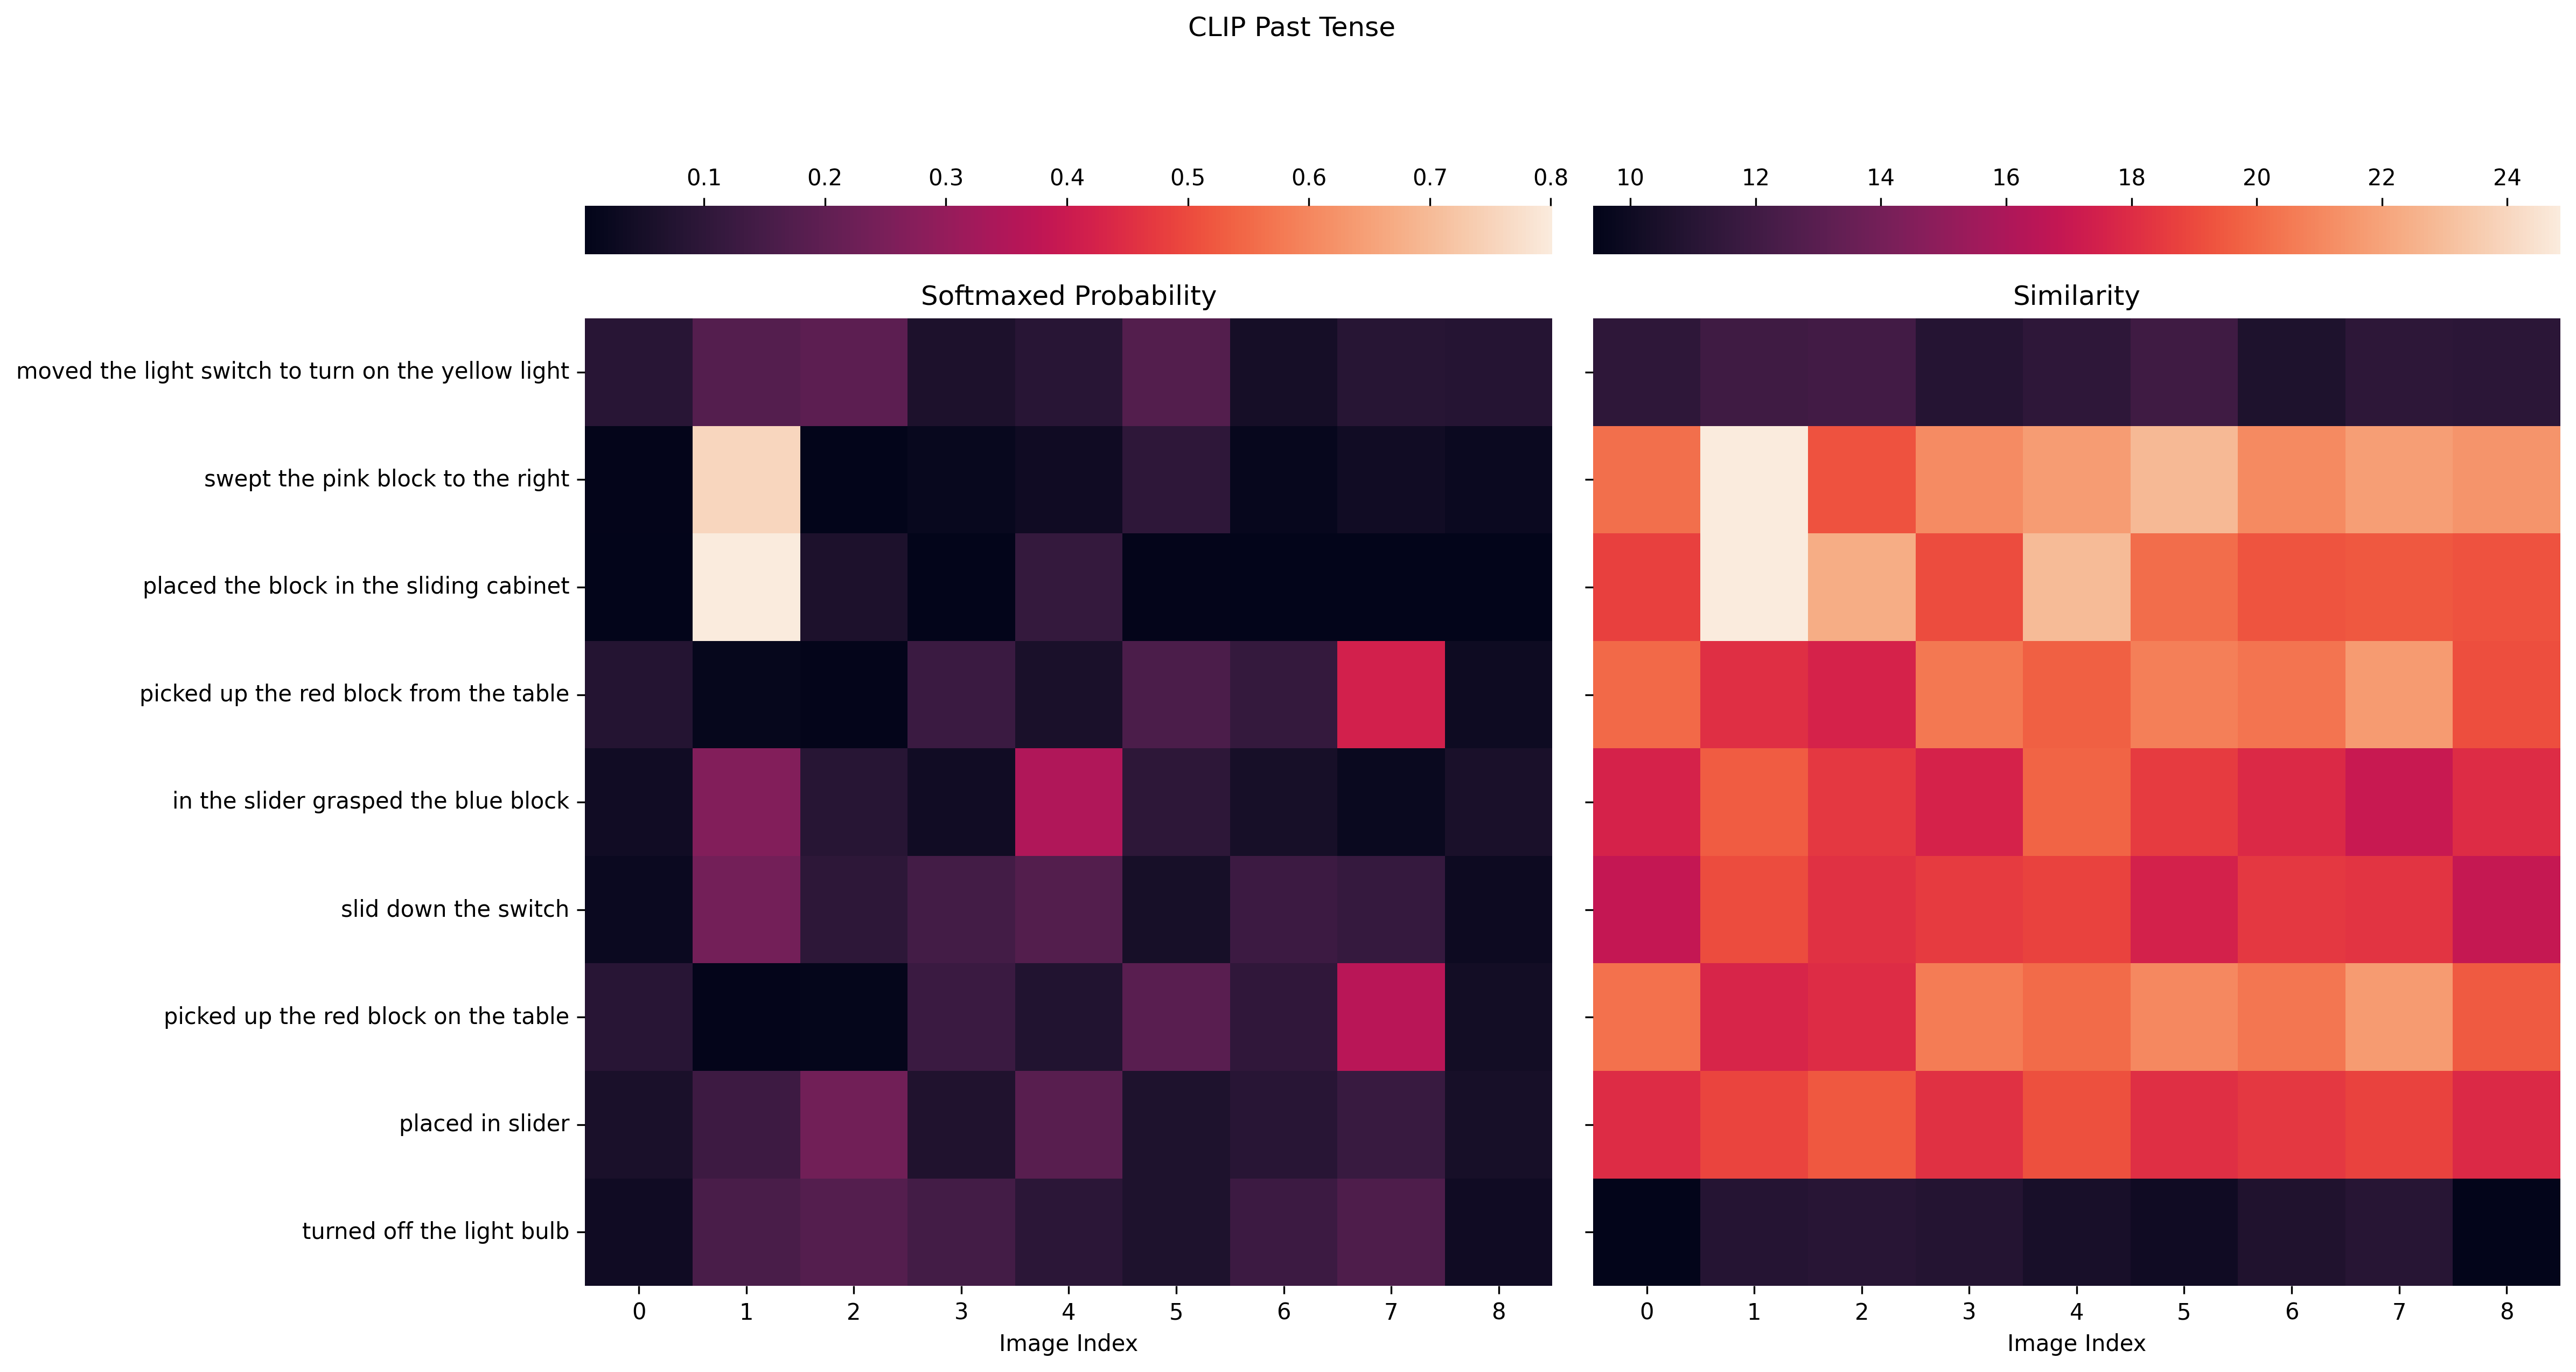

In [18]:
run_my_pipeline(
    past_tense_lang_anns, images, clip_processor, clip_model, "CLIP Past Tense"
)

ALIGN Past Tense
calculating similarity


/Users/thesofakillers/miniconda3/envs/thesis/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


plotting


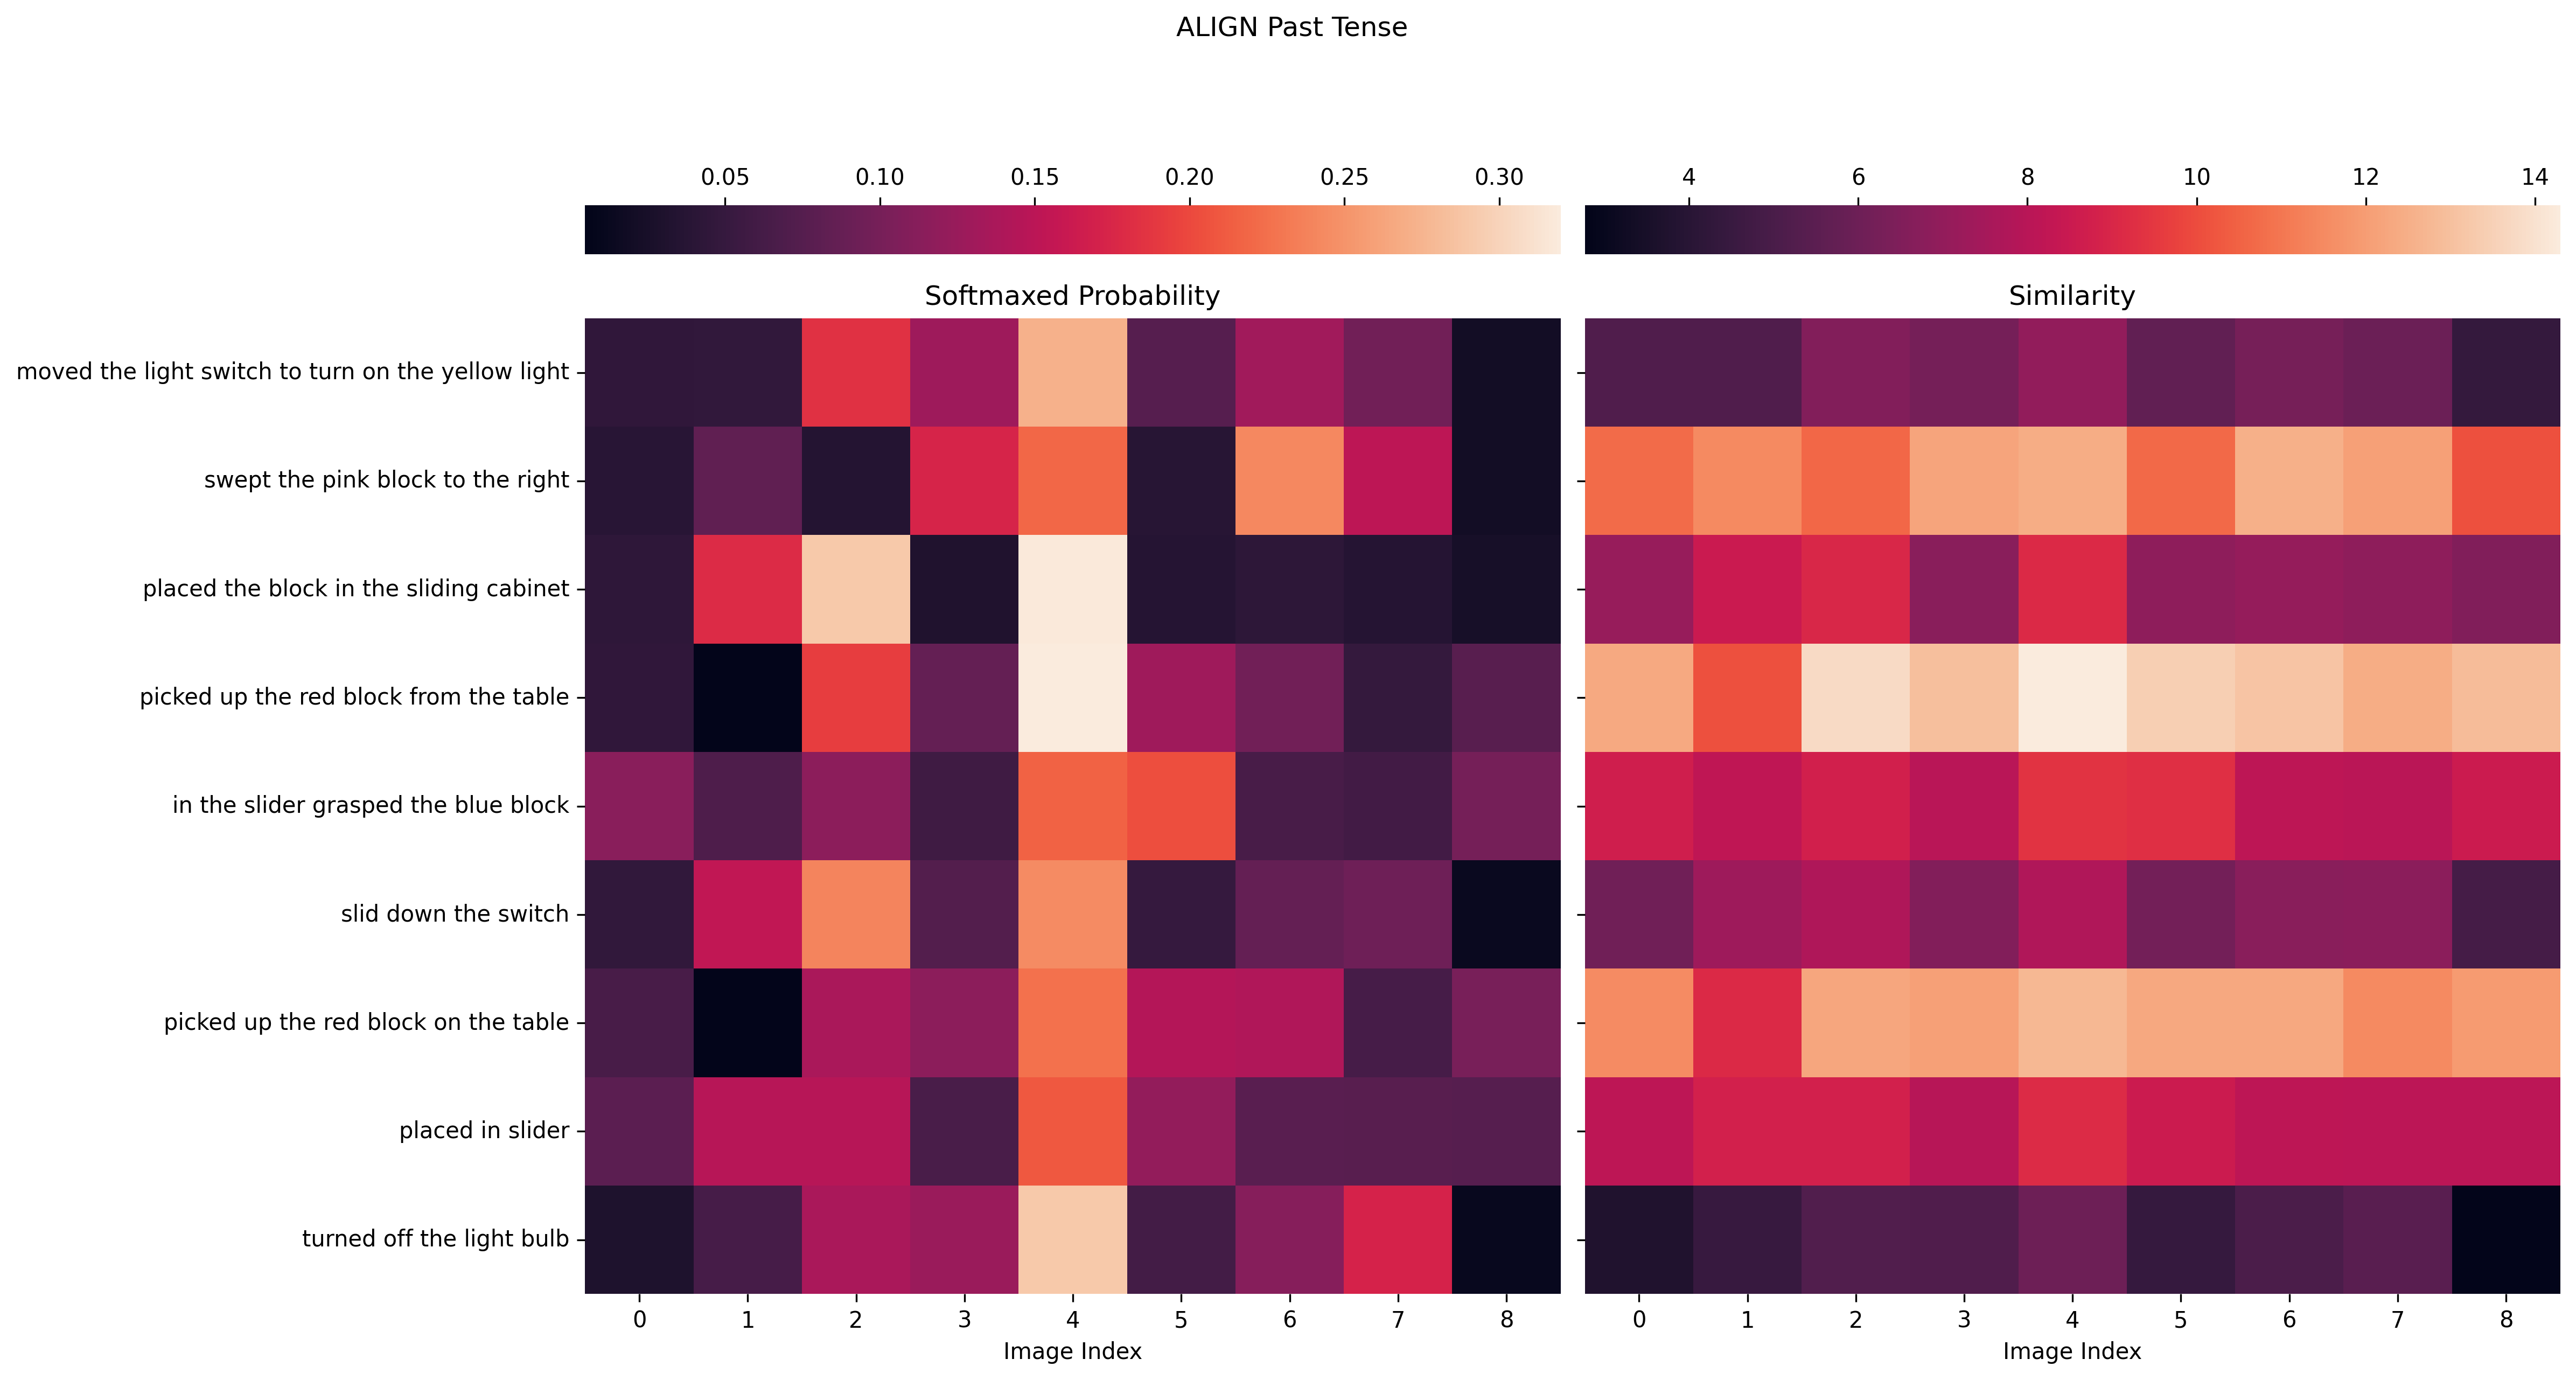

In [20]:
run_my_pipeline(
    past_tense_lang_anns, images, align_processor, align_model, "ALIGN Past Tense"
)

`input_ids_masked` isn't passed which means MLM loss won't be calculated correctlySetting it to `input_ids` so that model can work. Please pass it if this is unintentional. This is usually OKAY if you are doing inference on unmasked text...


FLAVA Past Tense
calculating similarity


/Users/thesofakillers/miniconda3/envs/thesis/lib/python3.8/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


plotting


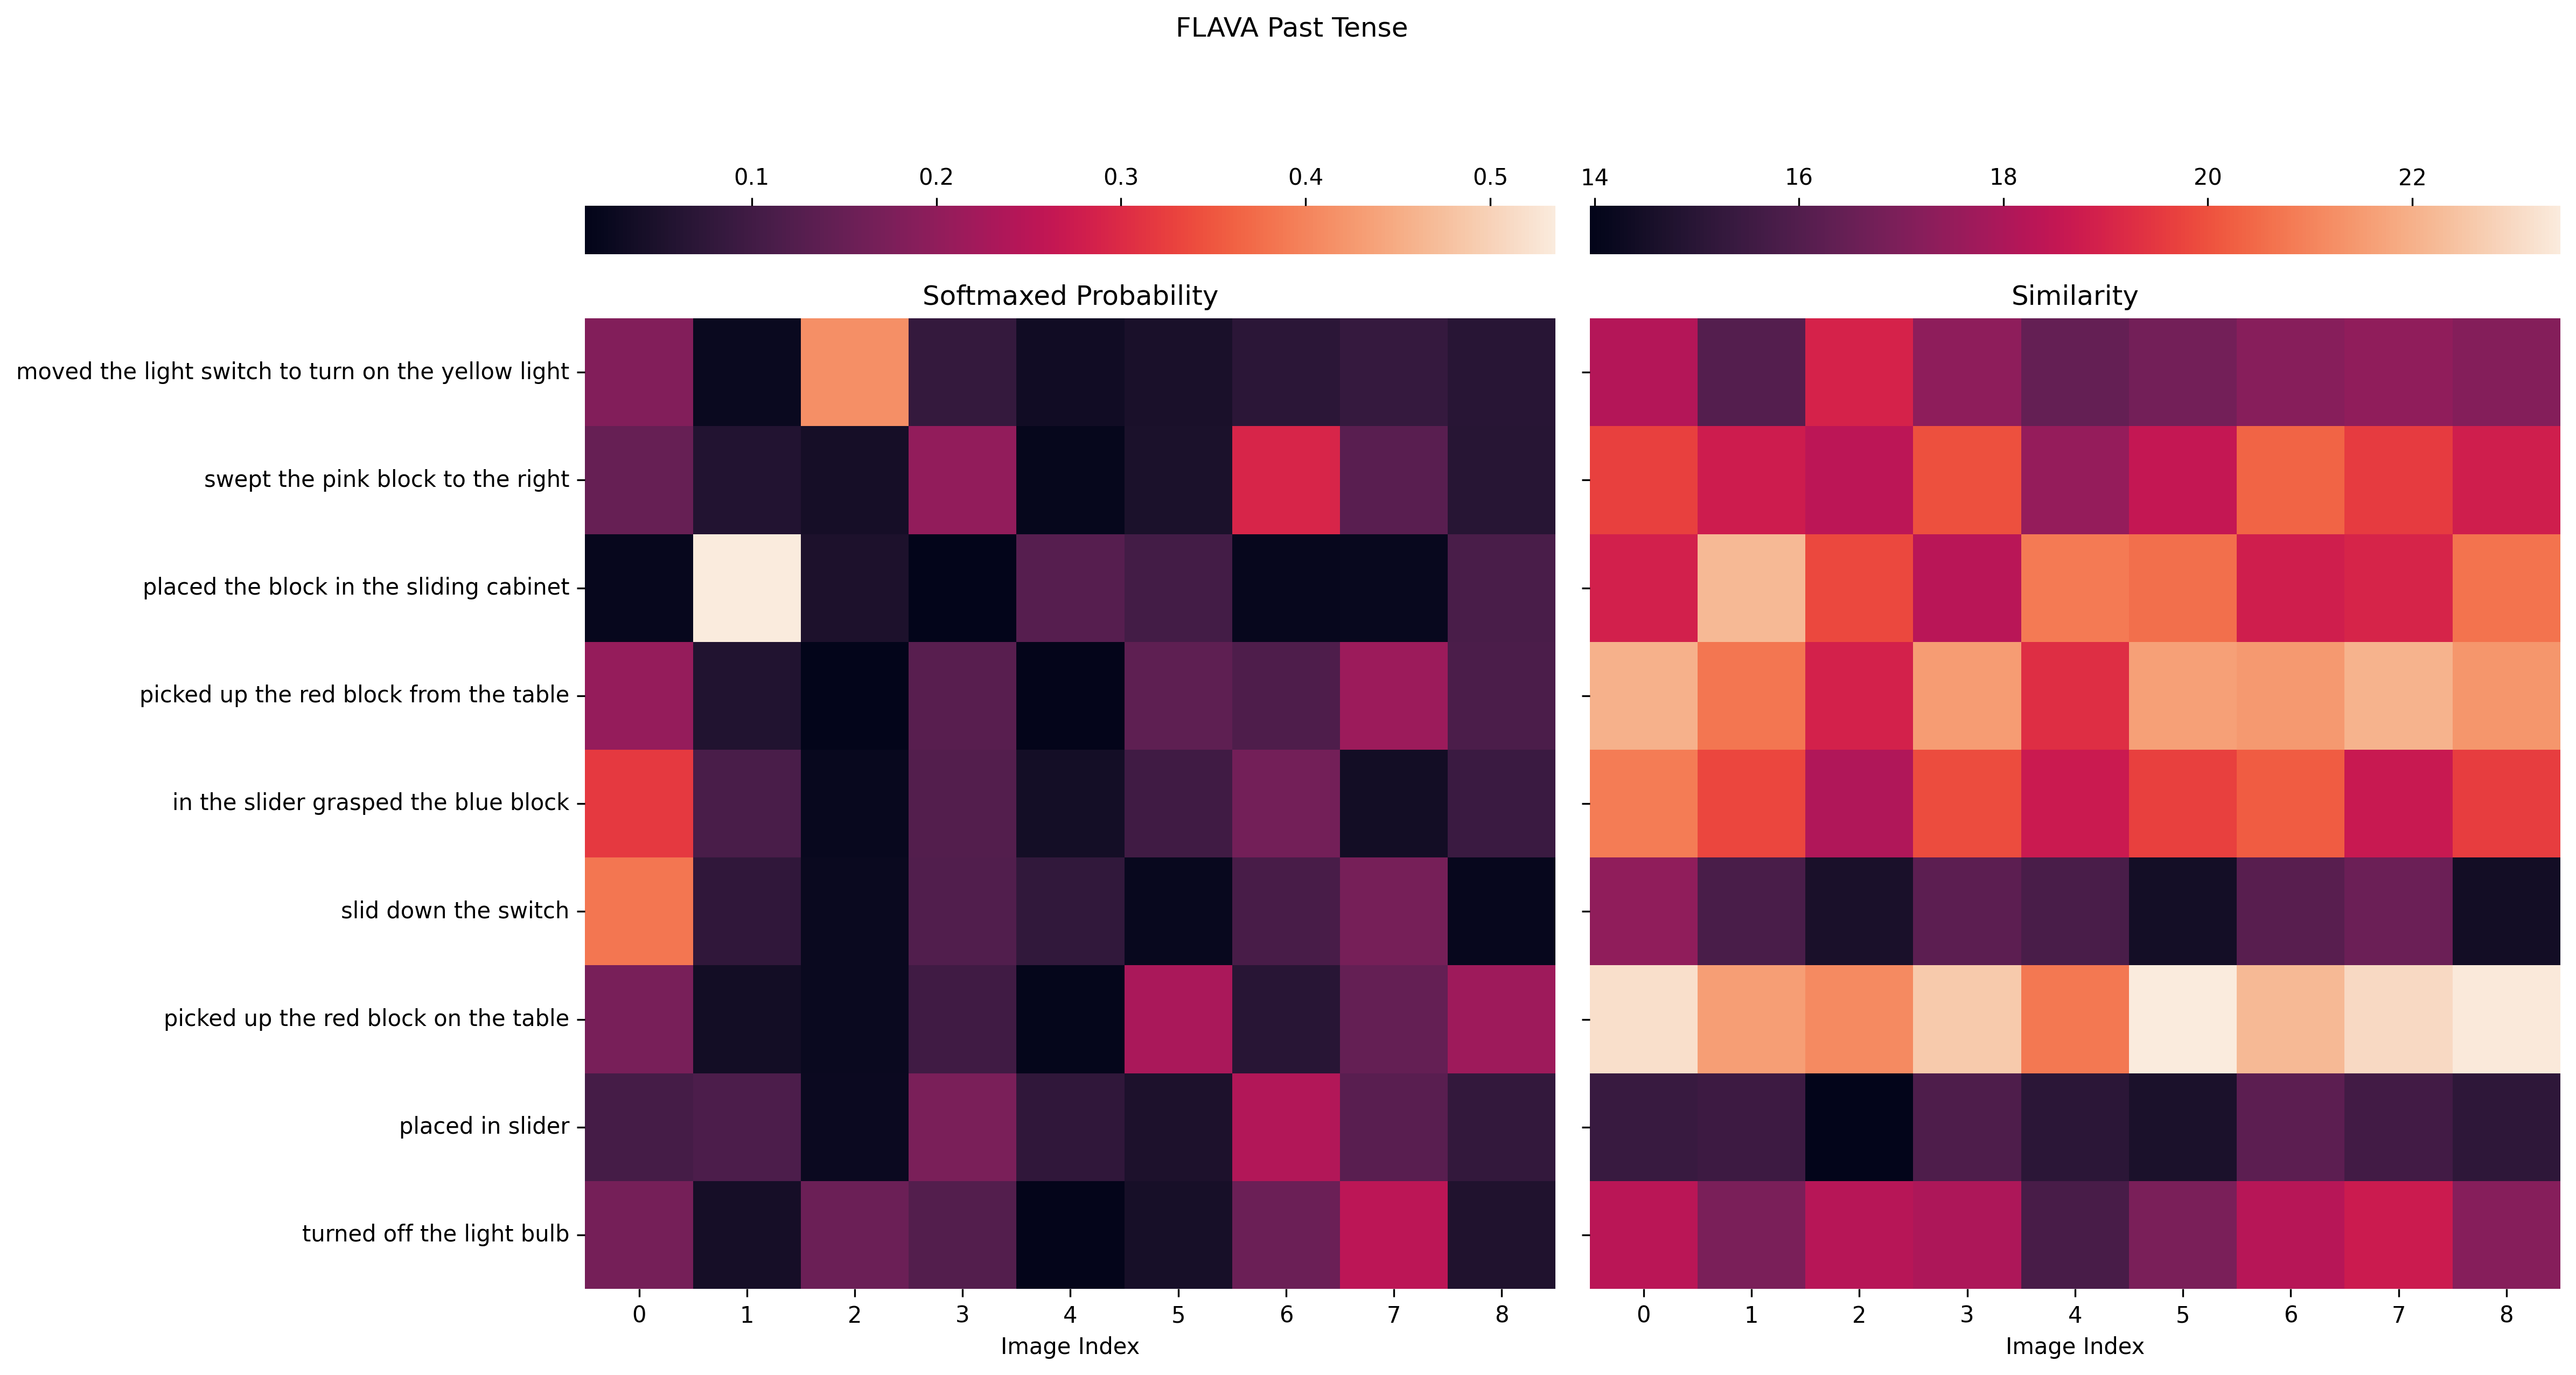

In [24]:
run_my_pipeline(
    past_tense_lang_anns,
    images,
    flava_processor,
    flava_model,
    "FLAVA Past Tense",
    "contrastive_logits_per_image",
    return_codebook_pixels=True,
    return_image_mask=True,
)

Past-tensification seems to help a very small, probably negligible amount.

### Paraphrasing Language annotations

In [25]:
lang_anns

['move the light switch to turn on the yellow light',
 'sweep the pink block to the right',
 'place the block in the sliding cabinet',
 'pick up the red block from the table',
 'in the slider grasp the blue block',
 'slide down the switch',
 'pick up the red block on the table',
 'place in slider',
 'turn off the light bulb']

In [32]:
# manually paraphrasing 
paraphrased_lang_anns = [
    "robotic arm moving the light switch such that the yellow light is now on",
    "robotic arm sweeping the pink block to the right",
    "robotic arm placing the block into the sliding cabinet",
    "robotic arm picking up the red block from the table",
    "robotic arm grasping the blue block while inside the slider cabinet",
    "robotic arm sliding down the switch",
    "robotic arm picking up the red block from the table",
    "robotic arm placing an item in the slider cabinet",
    "robotic arm turning off the light bulb",
]

CLIP Paraphrased
calculating similarity
plotting


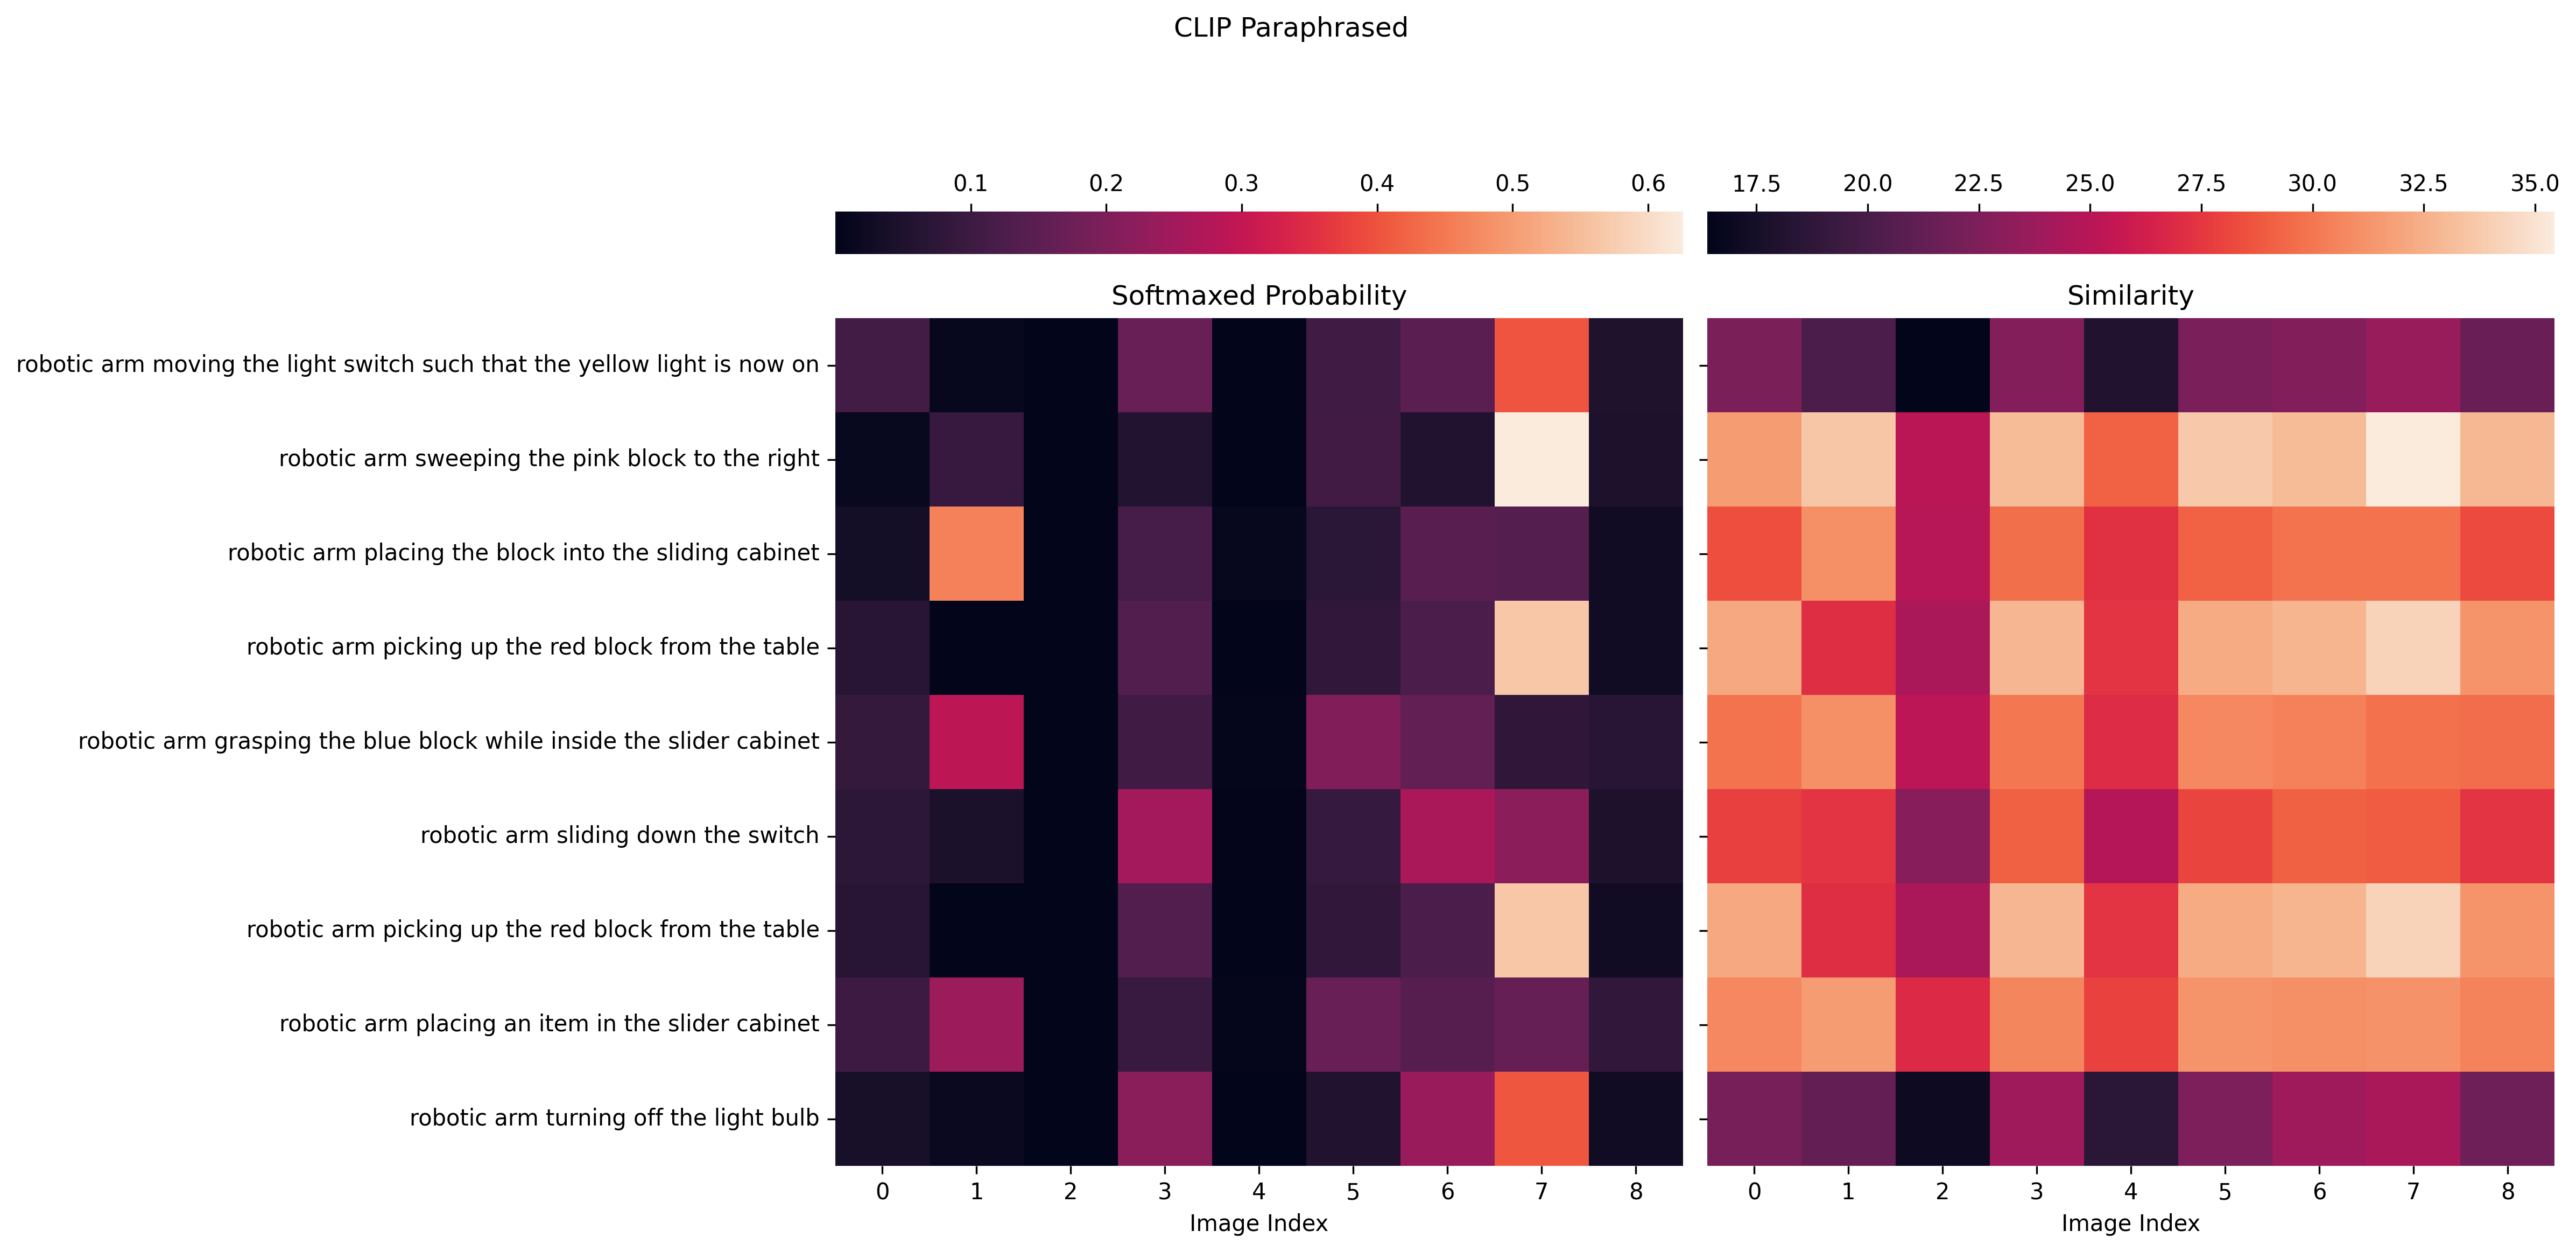

In [33]:
run_my_pipeline(
    paraphrased_lang_anns, images, clip_processor, clip_model, "CLIP Paraphrased"
)

ALIGN Paraphrased
calculating similarity


/Users/thesofakillers/miniconda3/envs/thesis/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


plotting


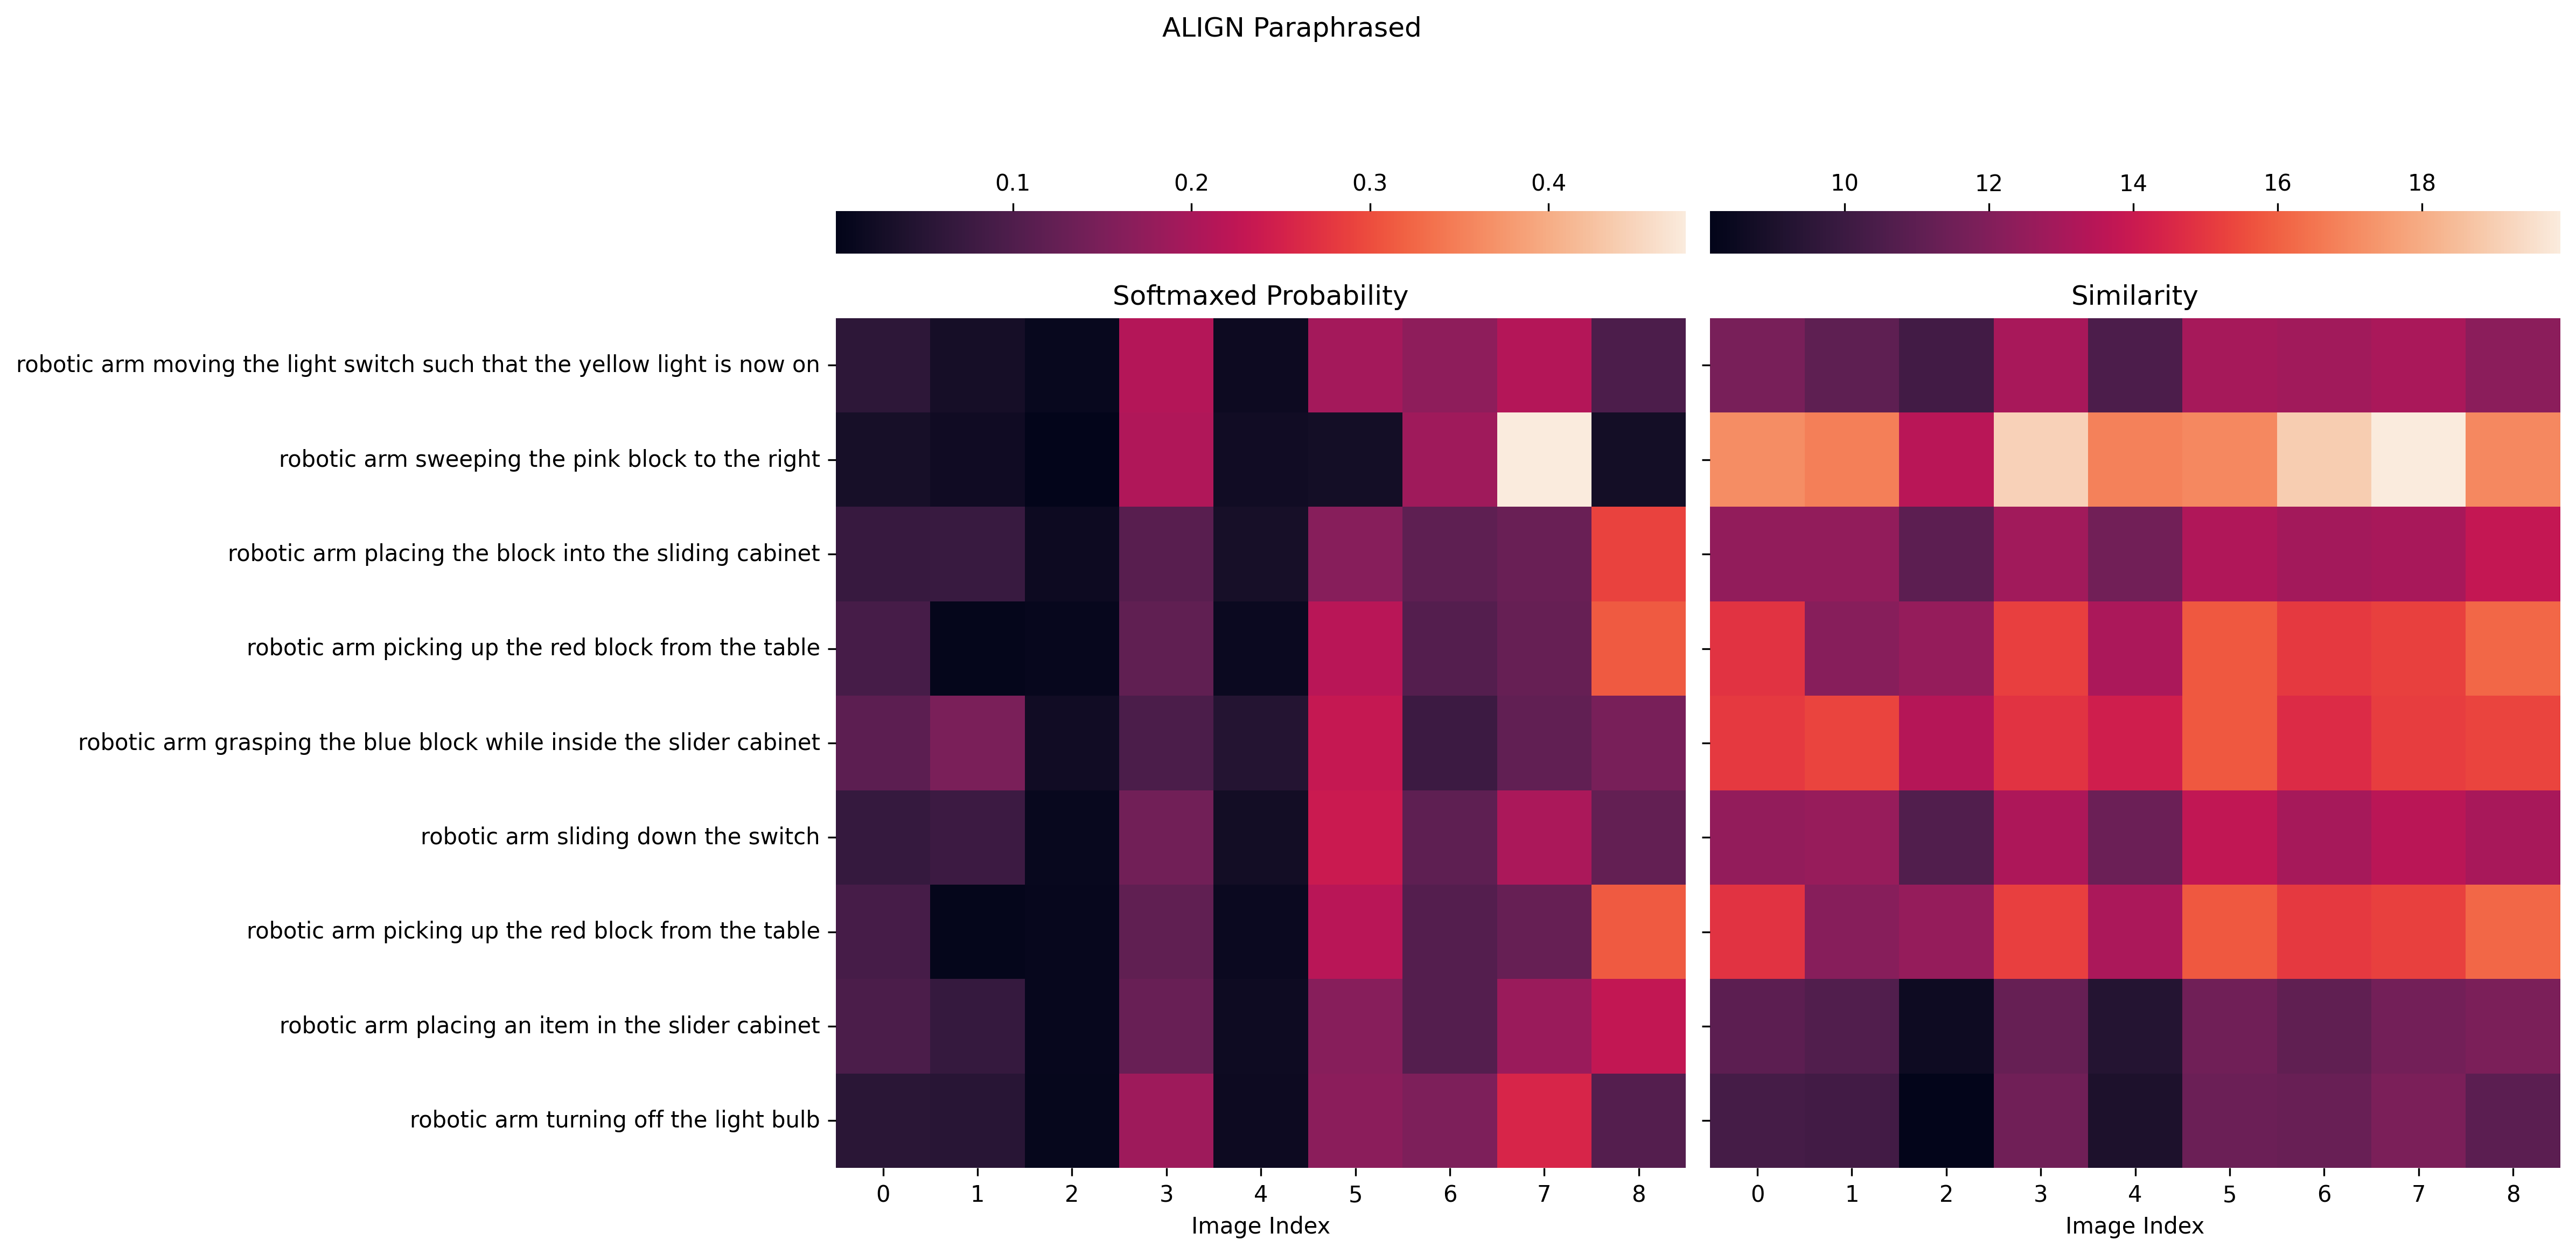

In [34]:
run_my_pipeline(
    paraphrased_lang_anns, images, align_processor, align_model, "ALIGN Paraphrased"
)

`input_ids_masked` isn't passed which means MLM loss won't be calculated correctlySetting it to `input_ids` so that model can work. Please pass it if this is unintentional. This is usually OKAY if you are doing inference on unmasked text...


FLAVA Paraphrased
calculating similarity


/Users/thesofakillers/miniconda3/envs/thesis/lib/python3.8/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


plotting


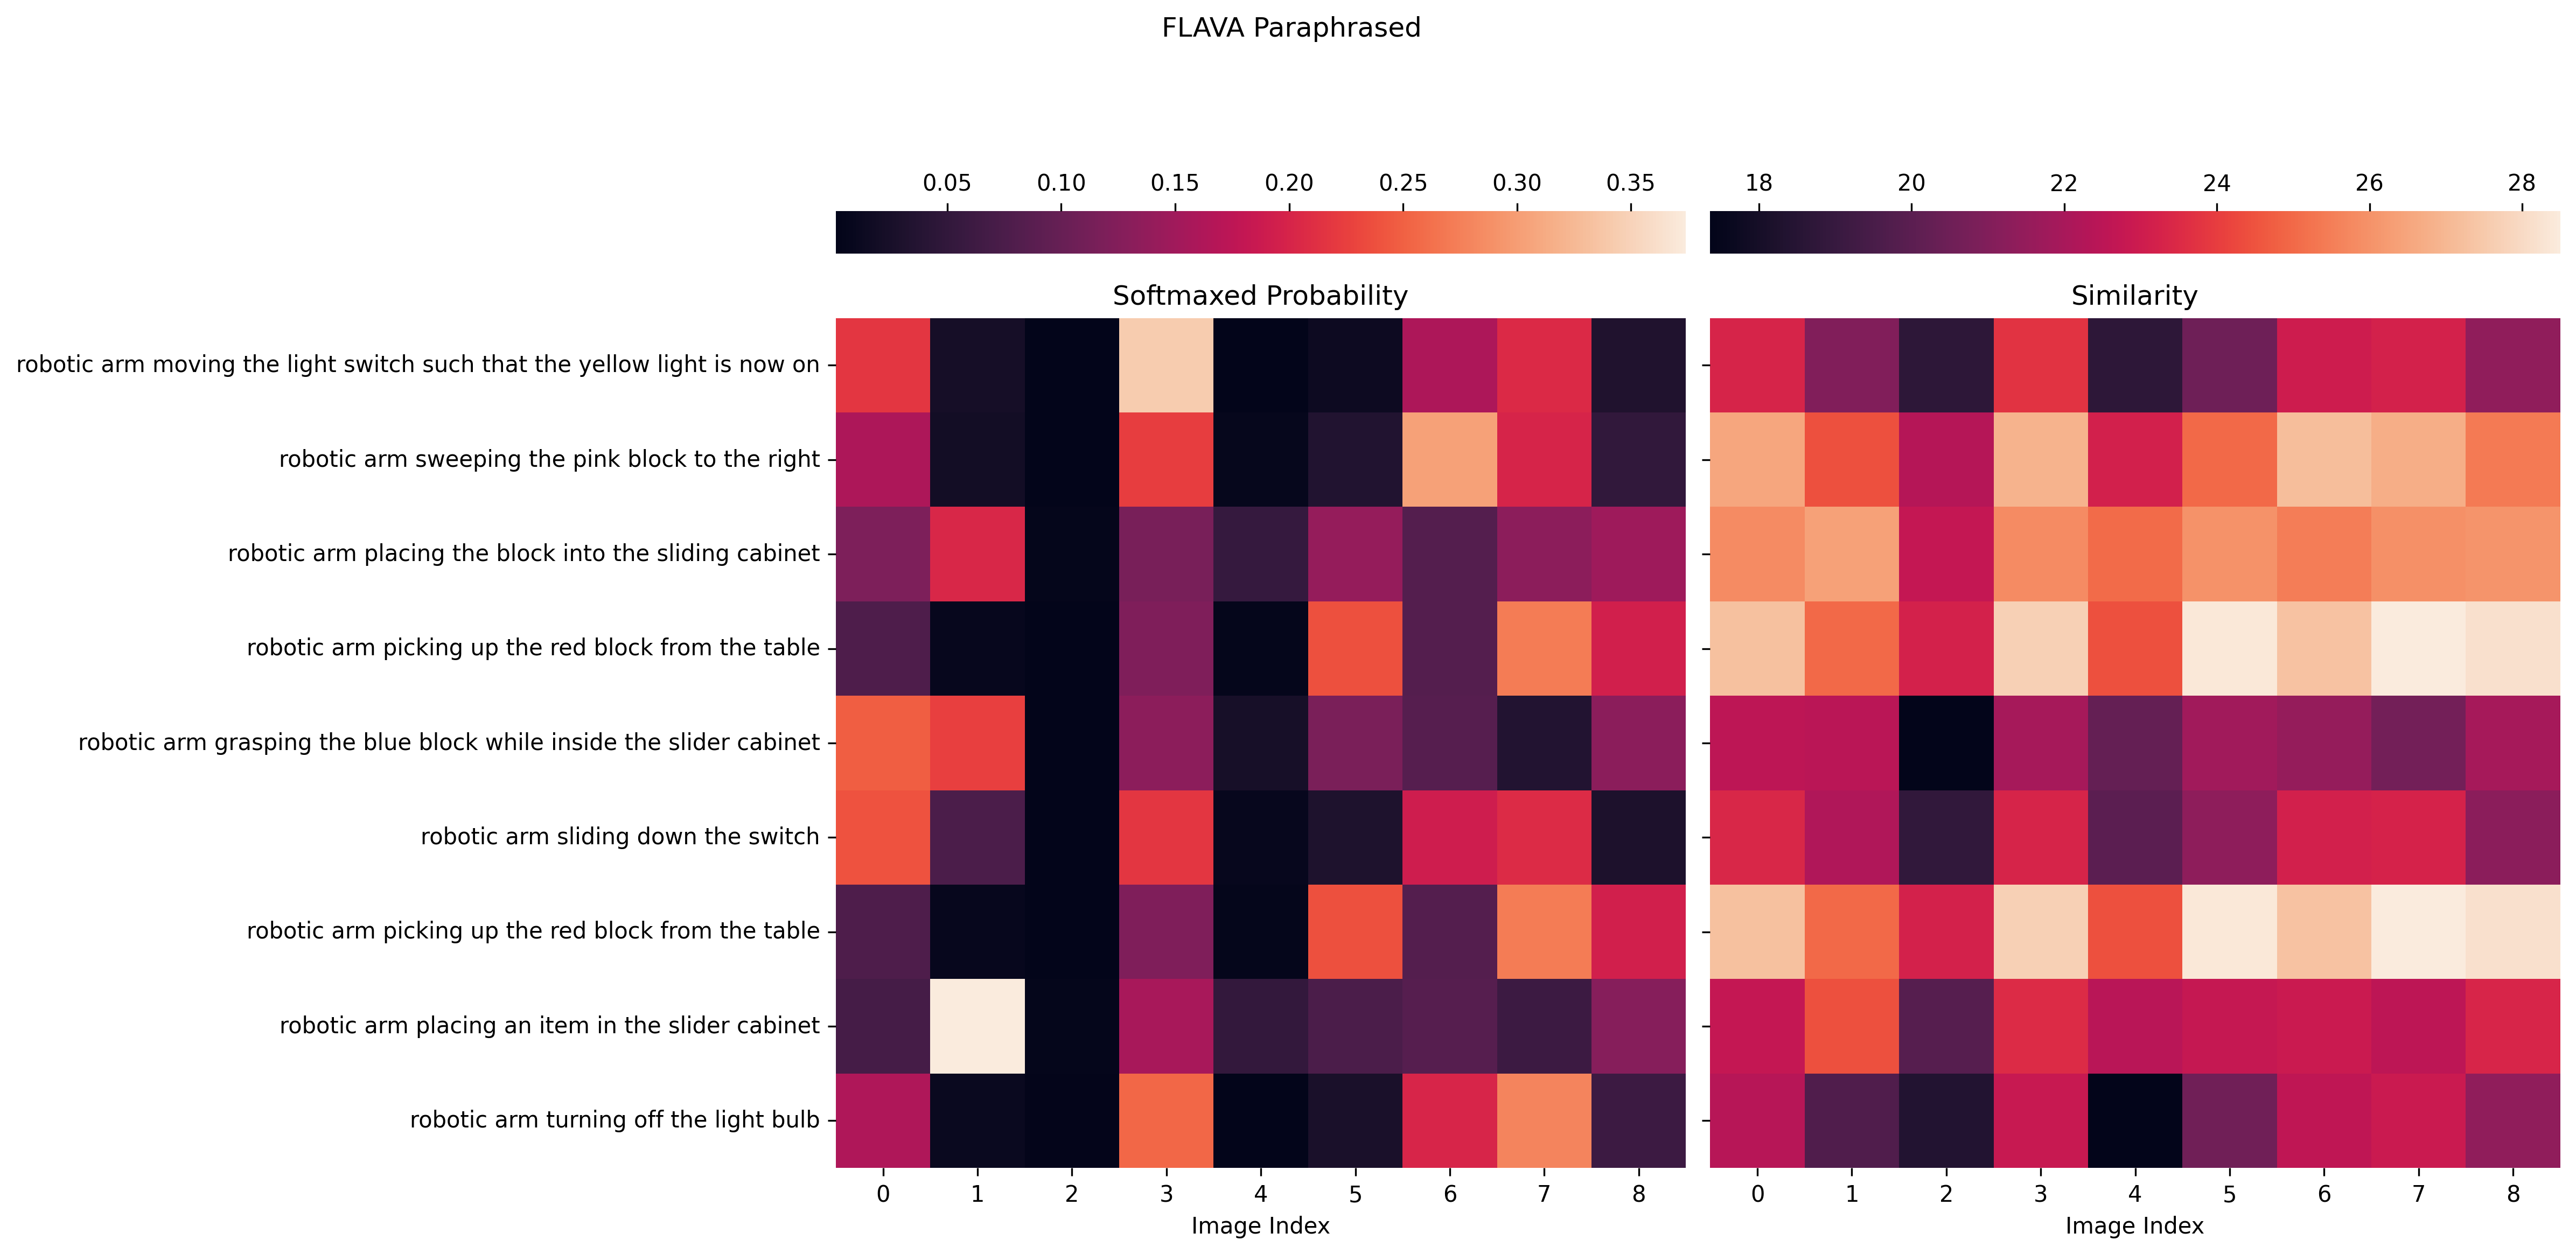

In [35]:
run_my_pipeline(
    paraphrased_lang_anns,
    images,
    flava_processor,
    flava_model,
    "FLAVA Paraphrased",
    "contrastive_logits_per_image",
    return_codebook_pixels=True,
    return_image_mask=True,
)

Overall prompt engineering doesn't seem to help a lot. I haven't tried many but I am not very hopeful.

Need to sit on this and think about it a bit more